<a href="https://colab.research.google.com/github/shayperetz6/AutoEncoder-for-Image-Inpainting/blob/main/AutoEncoder-for-Image-Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import PIL.Image as image
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from zmq.constants import XPUB
from keras.layers import *
from keras.models import Model
from tensorflow.python.ops.numpy_ops import np_config

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
IMAGE_SIZE = 56
images = os.listdir('/content/gdrive/MyDrive/data')
train_dir='/content/gdrive/MyDrive/data/'

In [ ]:

np_config.enable_numpy_behavior()
trains = tf.keras.utils.image_dataset_from_directory(train_dir,validation_split=0.3,subset="training",seed=123,image_size=(IMAGE_SIZE, IMAGE_SIZE),)
vals = tf.keras.utils.image_dataset_from_directory(train_dir,validation_split=0.3,subset="validation",seed=123,image_size=(IMAGE_SIZE, IMAGE_SIZE),)
trains = trains.unbatch()
vals = vals.unbatch()
train = []
test = []
for x,y in trains:
    train.append(x.astype('float32')/255.)
for x,y in vals:
    test.append(x.astype('float32')/255.)
train = tf.convert_to_tensor(train)
test = tf.convert_to_tensor(test)

Found 299 files belonging to 1 classes.
Using 210 files for training.
Found 299 files belonging to 1 classes.
Using 89 files for validation.


In [ ]:
print(train.shape)
print(test.shape)

(210, 56, 56, 3)
(89, 56, 56, 3)


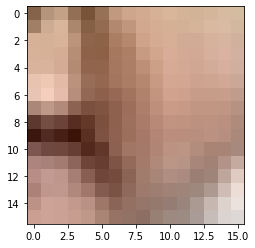

In [ ]:
#generating masks
left = 30
right = 46
up = 48
down = 32
x_train = train.numpy()
black_train = x_train.copy()
black_train[:,left:right,down:up,:] = 0
train_labels = x_train[:,left:right,down:up,:]
x_test = test.numpy()
black_test = x_test.copy()
black_test[:,left:right,down:up,:] = 0
test_labels = x_test[:,left:right,down:up,:]
plt.imshow(black_test[80])
# plt.imshow(test_labels[80])


In [ ]:
encoder_in = tf.keras.Input(shape=(56,56,3),name='img_input')
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Flatten()(layer)
encoder_out = tf.keras.layers.Dense(1024,activation='relu')(layer)     
decoder_in = tf.keras.layers.Dense(1024,activation='relu')(encoder_out)
layer = tf.keras.layers.Reshape((8,8,16))(decoder_in)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same')(layer)
layer = layer = tf.keras.layers.Conv2DTranspose(64,(3,3),activation='relu',padding='same')(layer)
layer = layer = tf.keras.layers.Conv2DTranspose(128,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same',strides=(2,2))(layer)
decoder_out = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same')(layer)


         
autoencoder = tf.keras.Model(encoder_in,decoder_out,name='an_dec')
autoencoder.summary()

Model: "an_dec"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 56, 56, 3)]       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 56, 56, 64)        1792      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 6272)              0    

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [ ]:
history = autoencoder.fit(black_train,train_labels ,
                epochs=1000,
                shuffle=True,
                batch_size=10,
                validation_data=(black_test,test_labels))

Epoch 1/1000
21/21 [==============================] - 1s 19ms/step - loss: 0.0357 - val_loss: 0.0373
Epoch 2/1000
21/21 [==============================] - 0s 10ms/step - loss: 0.0356 - val_loss: 0.0372
Epoch 3/1000
21/21 [==============================] - 0s 10ms/step - loss: 0.0355 - val_loss: 0.0372
Epoch 4/1000
21/21 [==============================] - 0s 8ms/step - loss: 0.0355 - val_loss: 0.0373
Epoch 5/1000
21/21 [==============================] - 0s 8ms/step - loss: 0.0355 - val_loss: 0.0373
Epoch 6/1000
21/21 [==============================] - 0s 8ms/step - loss: 0.0354 - val_loss: 0.0372
Epoch 7/1000
21/21 [==============================] - 0s 9ms/step - loss: 0.0354 - val_loss: 0.0372
Epoch 8/1000
21/21 [==============================] - 0s 8ms/step - loss: 0.0354 - val_loss: 0.0372
Epoch 9/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.0354 - val_loss: 0.0372
Epoch 10/1000
21/21 [==============================] - 0s 9ms/step - loss: 0.0353 - val_loss: 0.0

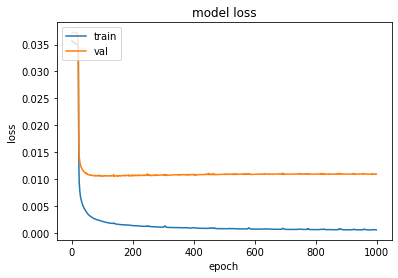

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

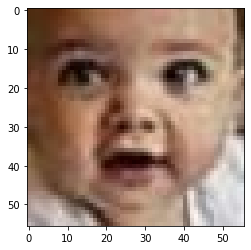

In [ ]:
index = 80
test_xs = black_test[index].copy()

test_xs[left:right,down:up] = test_labels[index]
plt.imshow(test_xs)

1/1 [==============================] - 0s 34ms/step


Text(0.5, 1.0, 'input')

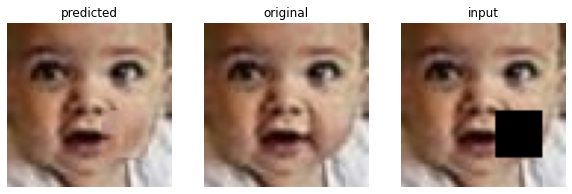

In [ ]:
index = 80
ry = autoencoder.predict(black_test[index].reshape(-1,56,56,3))
pic = black_test[index].copy()
pic[left:right,down:up] = ry
rows = 1
colls = 3
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows,colls,1)
plt.imshow(pic)
plt.axis('off')
plt.title("predicted")
test_xs = black_test[index].copy()
test_xs[left:right,down:up] = test_labels[index]
fig.add_subplot(rows,colls,2)
plt.imshow(test_xs)
plt.axis('off')
plt.title("original")
fig.add_subplot(rows,colls,3)
plt.imshow(black_test[index])
plt.axis('off')
plt.title("input")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~stop~~~~~~~~~~~~~~~~~~~~~~~